In [ ]:
# Instalação no Colab (ignore se já tiver instalado no local)
#!apt-get install tesseract-ocr -y
#!apt-get install tesseract-ocr-por -y
%pip install -q pytesseract opencv-python matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-por is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
#Importações necessárias
import cv2
import pytesseract
import matplotlib.pyplot as plt
import re

In [ ]:
class NotaFiscalOCR:
    """
    Classe responsável por realizar OCR em notas fiscais eletrônicas,
    utilizando Tesseract e OpenCV com pré-processamento.

    Atributos:
        lang (str): Idioma para o Tesseract (padrão 'por').
    """
    def __init__(self, lang='por'):
        """
        Inicializa a classe NotaFiscalOCR.

        Args:
            lang (str): Idioma para o Tesseract. Default é 'por' (português).
        """
        self.lang = lang
        self.tesseract_cmd = '/usr/bin/tesseract'
        pytesseract.pytesseract.tesseract_cmd = self.tesseract_cmd

    def carregar_imagem(self, caminho_imagem):
        """
        Carrega a imagem da nota fiscal a partir do caminho informado.

        Args:
            caminho_imagem (str): Caminho do arquivo de imagem.

        Returns:
            numpy.ndarray: Imagem carregada.

        Raises:
            FileNotFoundError: Se o arquivo não for encontrado.
        """
        imagem = cv2.imread(caminho_imagem)
        if imagem is None:
            raise FileNotFoundError(f"Imagem não encontrada: {caminho_imagem}")
        return imagem

    def exibir_imagem(self, imagem, titulo="Imagem"):
        """
        Exibe uma imagem utilizando Matplotlib.

        Args:
            imagem (numpy.ndarray): Imagem a ser exibida.
            titulo (str): Título da imagem na visualização.
        """
        plt.figure(figsize=(10, 10))
        if len(imagem.shape) == 2:
            plt.imshow(imagem, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))
        plt.title(titulo)
        plt.axis('off')
        plt.show()

    def preprocessar_imagem(self, imagem):
        """
        Realiza pré-processamento na imagem:
        - Conversão para escala de cinza.
        - Binarização com threshold fixo.

        Args:
            imagem (numpy.ndarray): Imagem original.

        Returns:
            numpy.ndarray: Imagem binarizada.
        """
        cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
        _, binarizada = cv2.threshold(cinza, 150, 255, cv2.THRESH_BINARY)
        return binarizada

    def extrair_texto(self, imagem_processada):
        """
        Executa o OCR utilizando Tesseract na imagem processada.

        Args:
            imagem_processada (numpy.ndarray): Imagem binarizada.

        Returns:
            str: Texto extraído.
        """
        config = r'--oem 3 --psm 6 -l {}'.format(self.lang)
        texto = pytesseract.image_to_string(imagem_processada, config=config)
        return texto

    def extrair_campos(self, texto):
        """
        Extrai campos específicos do texto utilizando expressões regulares:
        - CNPJs
        - Datas
        - Valores em R$

        Args:
            texto (str): Texto extraído pelo OCR.

        Returns:
            dict: Campos extraídos com listas de valores encontrados.
        """
        cnpj_pattern = r'\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2}'
        data_pattern = r'\d{2}/\d{2}/\d{4}'
        valor_pattern = r'R\$ ?\d{1,3}(?:\.\d{3})*,\d{2}'

        cnpjs = re.findall(cnpj_pattern, texto)
        datas = re.findall(data_pattern, texto)
        valores = re.findall(valor_pattern, texto)

        resultado = {
            'CNPJs': cnpjs,
            'Datas': datas,
            'Valores': valores
        }

        return resultado

    def processar_nota_fiscal(self, caminho_imagem):
        """
        Executa o pipeline completo:
        - Carrega e exibe a imagem original.
        - Pré-processa e exibe a imagem binarizada.
        - Realiza OCR e imprime o texto extraído.
        - Extrai campos específicos e os exibe.

        Args:
            caminho_imagem (str): Caminho do arquivo da nota fiscal.

        Returns:
            tuple: Texto extraído (str), campos extraídos (dict)
        """
        imagem = self.carregar_imagem(caminho_imagem)
        self.exibir_imagem(imagem, "Imagem Original")

        imagem_proc = self.preprocessar_imagem(imagem)
        self.exibir_imagem(imagem_proc, "Imagem Processada")

        texto = self.extrair_texto(imagem_proc)
        print("Texto extraído:\n")
        print(texto)

        campos = self.extrair_campos(texto)
        print("\nCampos encontrados:")
        for campo, valores in campos.items():
            print(f"{campo}: {valores}")

        return texto, campos

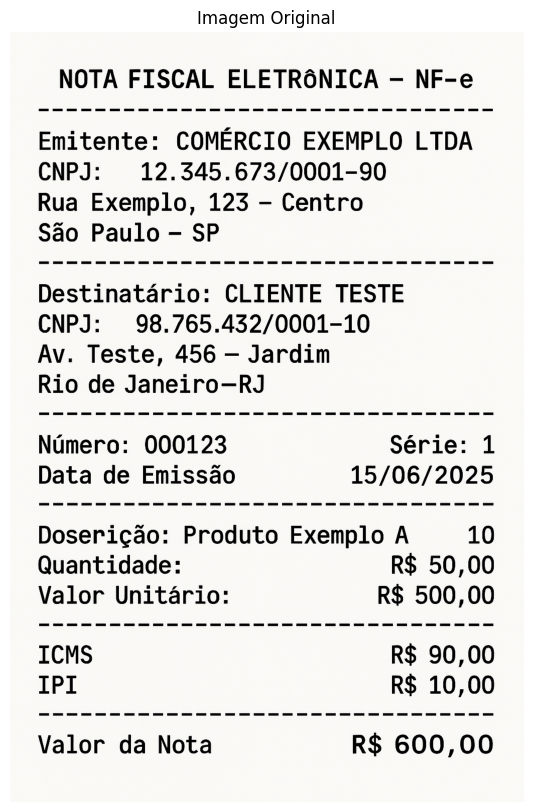

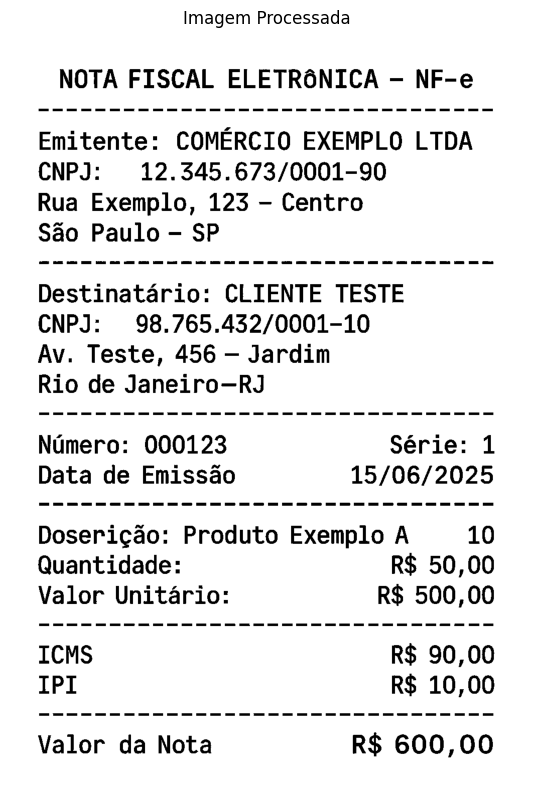

Texto extraído:

NOTA FISCAL ELETRÔNICA - NF-e
Emitente: COMÉRCIO EXEMPLO LTDA
CNPJ:  12.345.673/0001-90
Rua Exemplo, 123 - Centro
São Paulo - SP
Destinatário: CLIENTE TESTE
CNPJ:  98.765.432/0001-10
Av. Teste, 456 — Jardim
Rio de Janeiro-RJ
Número: 000123 Série: 1
Data de Emissão 15/06/2025
Doserição: Produto Exemplo A 10
Quantidade: R$ 50,00
Valor Unitário: R$ 500,00
ICMS R$ 90,00
IPI R$ 10,00
Valor da Nota R$ 600,00


Campos encontrados:
CNPJs: ['12.345.673/0001-90', '98.765.432/0001-10']
Datas: ['15/06/2025']
Valores: ['R$ 50,00', 'R$ 500,00', 'R$ 90,00', 'R$ 10,00', 'R$ 600,00']


In [ ]:
# Exemplo de uso
if __name__ == "__main__":
    caminho_imagem = 'nota_fiscal_exemplo.png'  # Nome do arquivo gerado
    ocr = NotaFiscalOCR()
    ocr.processar_nota_fiscal(caminho_imagem)